# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


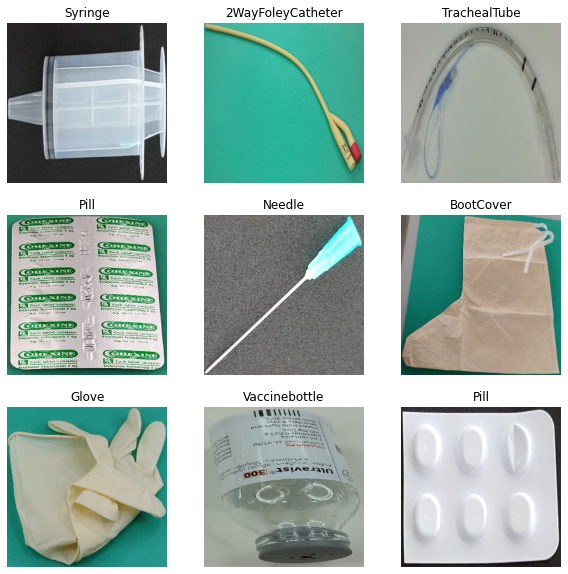

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(23, 299, 299, 3)
(23,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 21,852,361
Non-trainable params: 34,432
_________________________________________________________________


## Fitting

In [20]:
EPOCHS = 1000
save_model_interval = 10
checkpoint_filepath = 'D:/ModelMedicalWasteCheckpoint/Incepv3_OurOutputLayer-NoClassImbalanced-NoAug/OurOutputLayer-NoClassImbalanced-NoAug-epoch{epoch:03d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/1000
49/49 [==============================] - 69s 756ms/step - loss: 1.1039 - accuracy: 0.7034 - val_loss: 4.1954 - val_accuracy: 0.0336
Epoch 2/1000
49/49 [==============================] - 27s 559ms/step - loss: 0.3486 - accuracy: 0.8966 - val_loss: 6.4317 - val_accuracy: 0.1630
Epoch 3/1000
49/49 [==============================] - 27s 560ms/step - loss: 0.1899 - accuracy: 0.9396 - val_loss: 2.2749 - val_accuracy: 0.6003
Epoch 4/1000
49/49 [==============================] - 27s 561ms/step - loss: 0.1196 - accuracy: 0.9654 - val_loss: 1.1229 - val_accuracy: 0.7257
Epoch 5/1000
49/49 [==============================] - 27s 561ms/step - loss: 0.0821 - accuracy: 0.9761 - val_loss: 0.9000 - val_accuracy: 0.7620
Epoch 6/1000
49/49 [==============================] - 27s 562ms/step - loss: 0.0817 - accuracy: 0.9742 - val_loss: 1.9197 - val_accuracy: 0.6158
Epoch 7/1000
49/49 [==============================] - 28s 562ms/step - loss: 0.1217 - accuracy: 0.9645 - val_loss: 2.2128 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

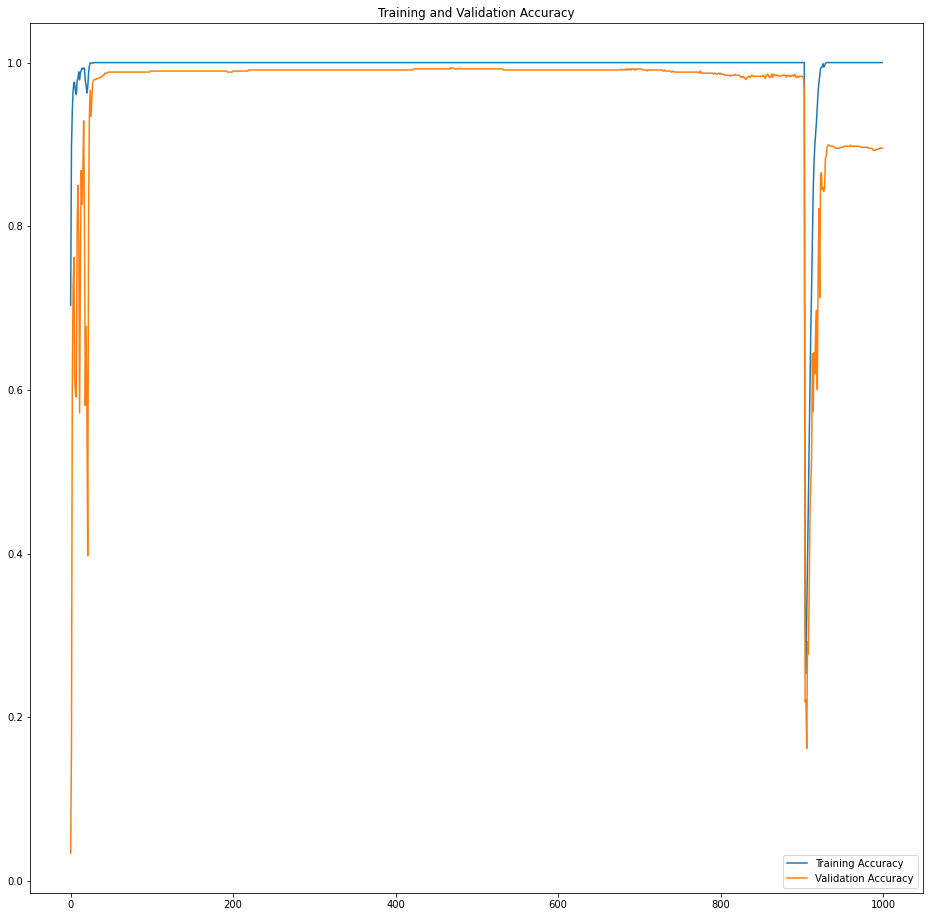

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


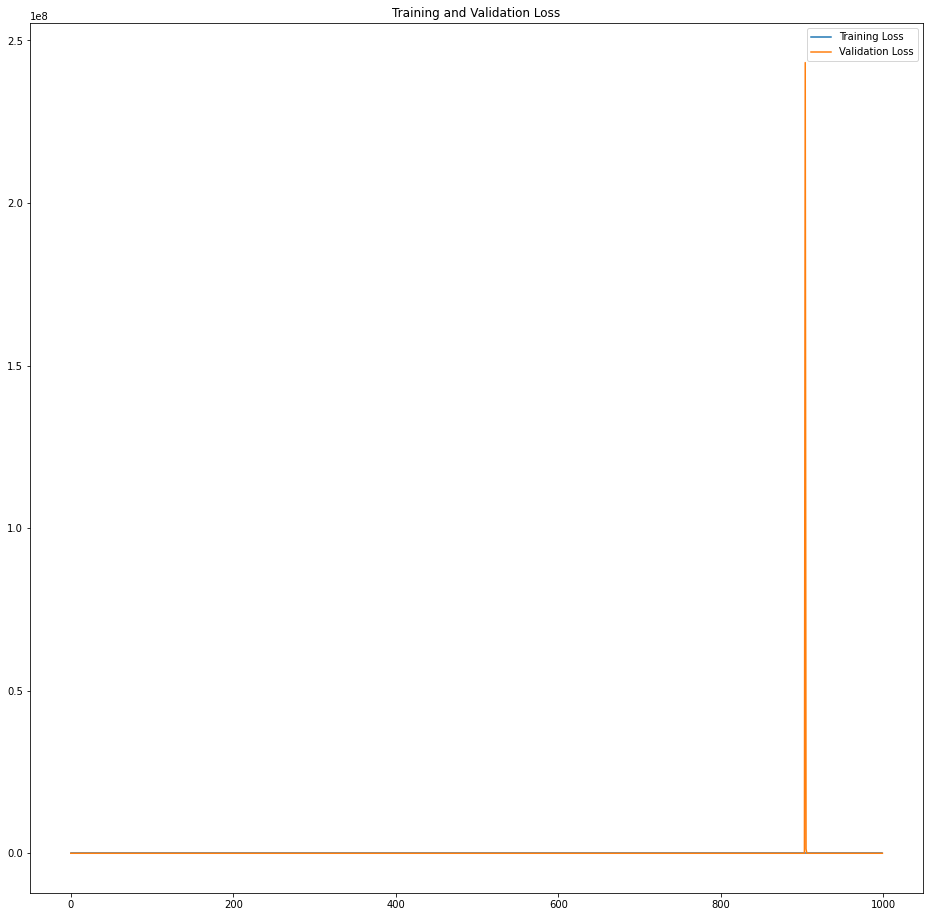

In [22]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 15s 367ms/step - loss: 19.3545 - accuracy: 0.1310
test_indoor_ds_results:test loss, test acc: [19.35453987121582, 0.13099218904972076]


In [24]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 454ms/step - loss: 9.6267 - accuracy: 0.2561
test_outdoor_ds_results:test loss, test acc: [9.62674617767334, 0.2560509443283081]


In [25]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 197ms/step - loss: 5.3827 - accuracy: 0.4574
test_belt_ds_results:test loss, test acc: [5.3827056884765625, 0.4573889374732971]


In [26]:
# Read path of trained model
import os, os.path
trained_path = 'D:/ModelMedicalWasteCheckpoint/Incepv3_OurOutputLayer-NoClassImbalanced-NoAug/'
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug/OurOutputLayer-NoClassImbalanced-NoAug-epoch010-val_acc0.85.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug/OurOutputLayer-NoClassImbalanced-NoAug-epoch020-val_acc0.68.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug/OurOutputLayer-NoClassImbalanced-NoAug-epoch030-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug/OurOutputLayer-NoClassImbalanced-NoAug-epoch040-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug/OurOutputLayer-NoClassImbalanced-NoAug-epoch050-val_acc0.99.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug/OurOutputLayer-NoClassImbalanced-NoAug-epoch060-val_acc0.99.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced-NoAug/OurOutputLayer-NoClassImbalanced-NoAug-epoch070-val_acc0.99.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutpu

In [27]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 143ms/step - loss: 2.5089 - accuracy: 0.5340
Epoch010 
 test_indoor_acc=0.22408026456832886 
 test_outdoor_acc=0.4216560423374176 
 test_belt_acc=0.5339981913566589
35/35 [==============================] - 5s 143ms/step - loss: 3.9533 - accuracy: 0.3740
Epoch020 
 test_indoor_acc=0.19230769574642181 
 test_outdoor_acc=0.19936305284500122 
 test_belt_acc=0.3739800453186035
35/35 [==============================] - 5s 141ms/step - loss: 1.3140 - accuracy: 0.7457
Epoch030 
 test_indoor_acc=0.4186176061630249 
 test_outdoor_acc=0.57834392786026 
 test_belt_acc=0.745693564414978
35/35 [==============================] - 5s 142ms/step - loss: 1.2232 - accuracy: 0.7539
Epoch040 
 test_indoor_acc=0.45261985063552856 
 test_outdoor_acc=0.5770700573921204 
 test_belt_acc=0.7538531422615051
35/35 [==============================] - 5s 142ms/step - loss: 1.2352 - accuracy: 0.7557
Epoch050 
 test_indoor_acc=0.4609810411930084 
 test_outdoor_acc=0.58407640457

range(10, 1010, 10)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

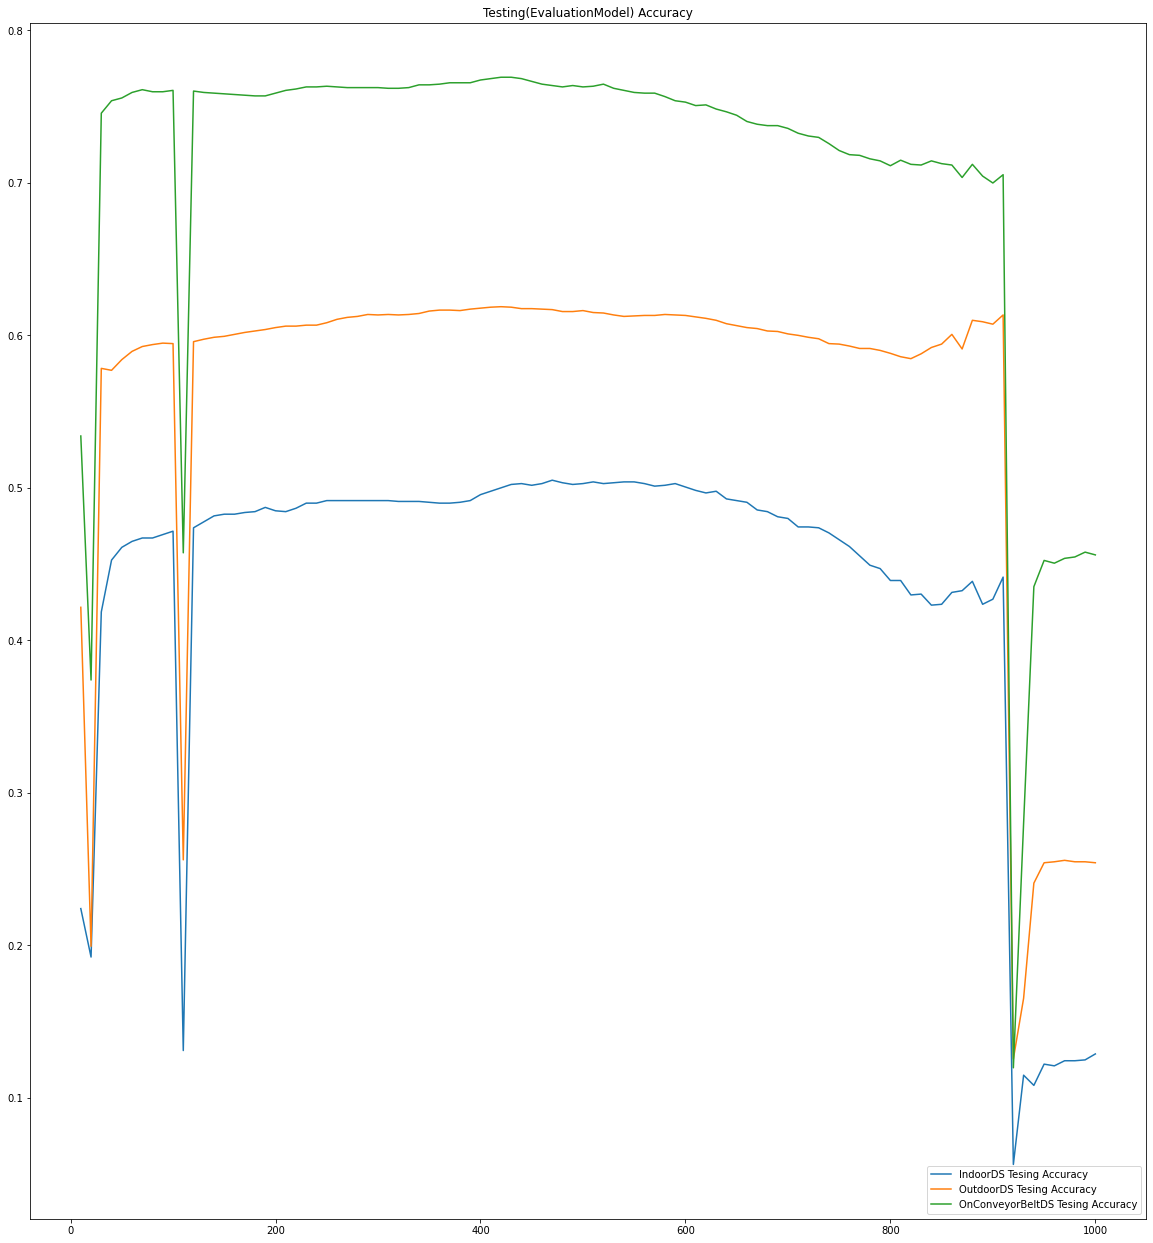

In [28]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

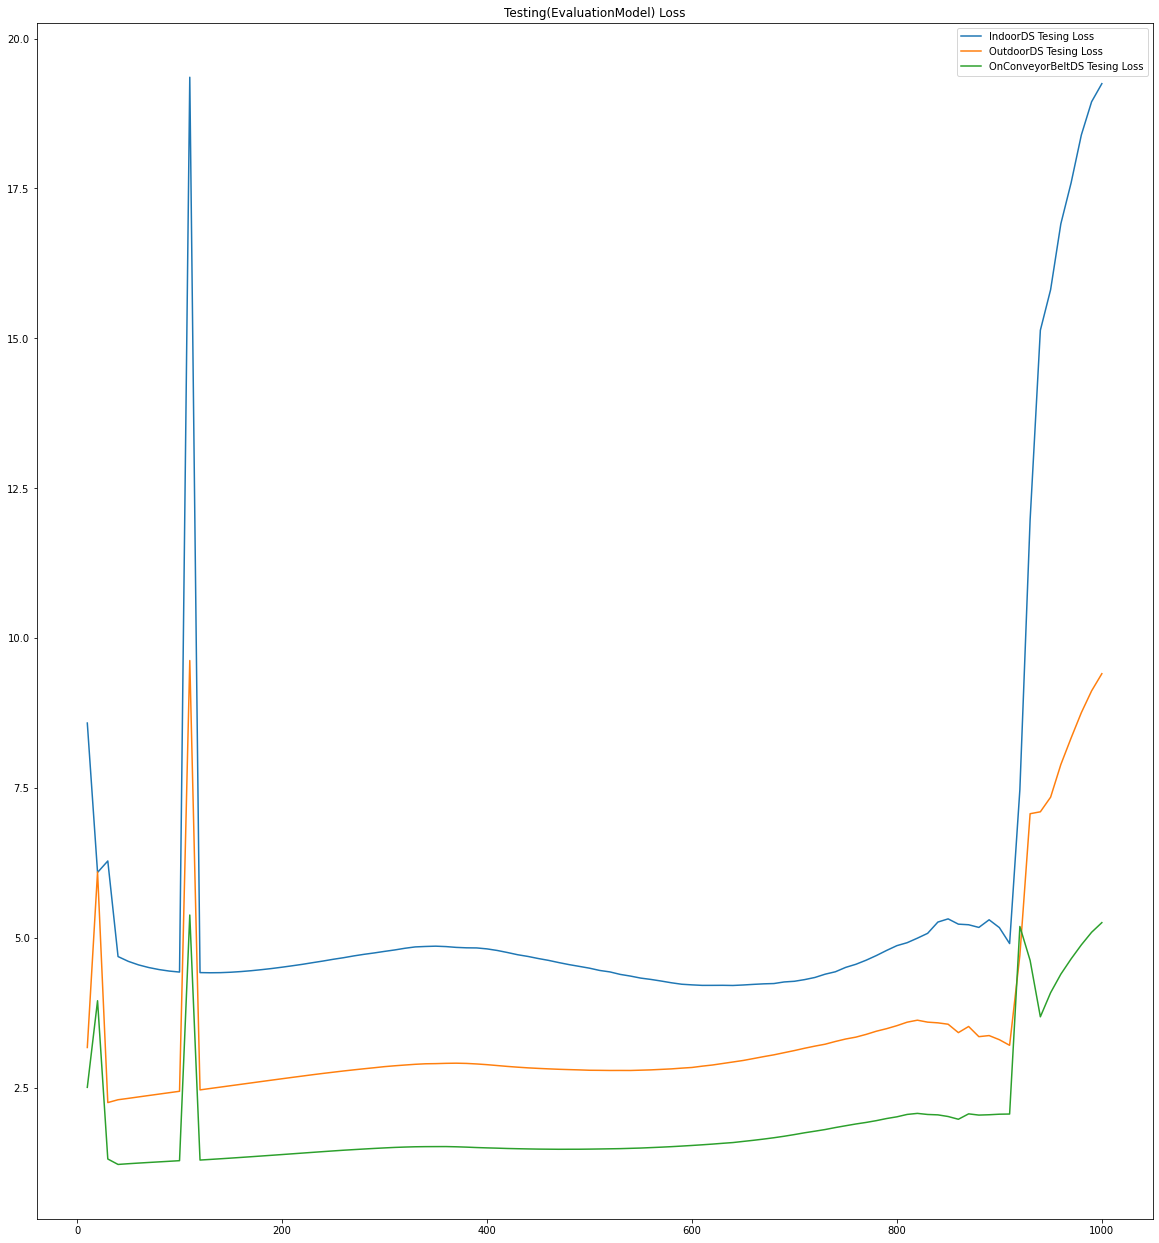

In [29]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [30]:
test_indoor_acc

[0.22408026456832886,
 0.19230769574642181,
 0.4186176061630249,
 0.45261985063552856,
 0.4609810411930084,
 0.4648829400539398,
 0.46711260080337524,
 0.46711260080337524,
 0.46934226155281067,
 0.4715718924999237,
 0.13099218904972076,
 0.47380155324935913,
 0.4777034521102905,
 0.4816053509712219,
 0.48272016644477844,
 0.48272016644477844,
 0.48383501172065735,
 0.4843924045562744,
 0.4871794879436493,
 0.48494982719421387,
 0.4843924045562744,
 0.48662206530570984,
 0.4899665415287018,
 0.4899665415287018,
 0.49163880944252014,
 0.49163880944252014,
 0.49163880944252014,
 0.49163880944252014,
 0.49163880944252014,
 0.49163880944252014,
 0.49163880944252014,
 0.4910813868045807,
 0.4910813868045807,
 0.4910813868045807,
 0.49052396416664124,
 0.4899665415287018,
 0.4899665415287018,
 0.49052396416664124,
 0.49163880944252014,
 0.49554067850112915,
 0.4977703392505646,
 0.5,
 0.502229630947113,
 0.5027870535850525,
 0.5016722679138184,
 0.5027870535850525,
 0.5050167441368103,
 0.50

In [31]:
test_outdoor_acc

[0.4216560423374176,
 0.19936305284500122,
 0.57834392786026,
 0.5770700573921204,
 0.5840764045715332,
 0.5894904732704163,
 0.5926751494407654,
 0.593949019908905,
 0.5949044823646545,
 0.5945860147476196,
 0.2560509443283081,
 0.5958598852157593,
 0.5974522233009338,
 0.5987260937690735,
 0.5993630290031433,
 0.6006369590759277,
 0.6019108295440674,
 0.6028662323951721,
 0.6038216352462769,
 0.6050955653190613,
 0.606050968170166,
 0.606050968170166,
 0.6066879034042358,
 0.6066879034042358,
 0.6082802414894104,
 0.6105095744132996,
 0.6117834448814392,
 0.612420380115509,
 0.6136942505836487,
 0.6133757829666138,
 0.6136942505836487,
 0.6133757829666138,
 0.6136942505836487,
 0.6143311858177185,
 0.6159235835075378,
 0.6165605187416077,
 0.6165605187416077,
 0.6162420511245728,
 0.6171974539756775,
 0.6178343892097473,
 0.6184713244438171,
 0.618789792060852,
 0.6184713244438171,
 0.6175159215927124,
 0.6175159215927124,
 0.6171974539756775,
 0.6168789863586426,
 0.6156051158905029

In [32]:
test_belt_acc

[0.5339981913566589,
 0.3739800453186035,
 0.745693564414978,
 0.7538531422615051,
 0.7556663751602173,
 0.7592928409576416,
 0.7611060738563538,
 0.7597461342811584,
 0.7597461342811584,
 0.7606527805328369,
 0.4573889374732971,
 0.7601994276046753,
 0.7592928409576416,
 0.7588395476341248,
 0.7583861947059631,
 0.7579329013824463,
 0.7574796080589294,
 0.7570263147354126,
 0.7570263147354126,
 0.7588395476341248,
 0.7606527805328369,
 0.7615593671798706,
 0.7629193067550659,
 0.7629193067550659,
 0.7633726000785828,
 0.7629193067550659,
 0.7624660134315491,
 0.7624660134315491,
 0.7624660134315491,
 0.7624660134315491,
 0.7620127201080322,
 0.7620127201080322,
 0.7624660134315491,
 0.7642792463302612,
 0.7642792463302612,
 0.7647325396537781,
 0.7656391859054565,
 0.7656391859054565,
 0.7656391859054565,
 0.7674524188041687,
 0.7683590054512024,
 0.7692656517028809,
 0.7692656517028809,
 0.7683590054512024,
 0.7665457725524902,
 0.7647325396537781,
 0.7638259530067444,
 0.76291930675

In [33]:
test_indoor_loss

[8.584421157836914,
 6.093125820159912,
 6.28407621383667,
 4.690028667449951,
 4.610262870788574,
 4.551089763641357,
 4.506882190704346,
 4.473099708557129,
 4.4480204582214355,
 4.431426525115967,
 19.35453987121582,
 4.422524452209473,
 4.419793605804443,
 4.421656608581543,
 4.428680896759033,
 4.439789295196533,
 4.454178810119629,
 4.471502780914307,
 4.490697383880615,
 4.51265811920166,
 4.536205291748047,
 4.560762882232666,
 4.588545799255371,
 4.615344524383545,
 4.6446533203125,
 4.670766353607178,
 4.700757026672363,
 4.727245330810547,
 4.750472545623779,
 4.776254653930664,
 4.800338268280029,
 4.828437805175781,
 4.850867748260498,
 4.858382701873779,
 4.863243579864502,
 4.856329917907715,
 4.842958450317383,
 4.835846900939941,
 4.833899974822998,
 4.818070888519287,
 4.791731834411621,
 4.757474422454834,
 4.720336437225342,
 4.692024230957031,
 4.6575164794921875,
 4.626709938049316,
 4.589978218078613,
 4.556023120880127,
 4.526464939117432,
 4.496400833129883,
 4

In [34]:
test_outdoor_loss

[3.1734519004821777,
 6.101778984069824,
 2.255094051361084,
 2.3022396564483643,
 2.3251001834869385,
 2.349182605743408,
 2.372804641723633,
 2.3962976932525635,
 2.419872999191284,
 2.4432201385498047,
 9.62674617767334,
 2.4664978981018066,
 2.490010976791382,
 2.513253688812256,
 2.5365328788757324,
 2.559715747833252,
 2.5829503536224365,
 2.606313467025757,
 2.6294105052948,
 2.6522364616394043,
 2.675035238265991,
 2.6973373889923096,
 2.719804048538208,
 2.741143226623535,
 2.761525869369507,
 2.7819459438323975,
 2.8006539344787598,
 2.818791389465332,
 2.8360378742218018,
 2.8542978763580322,
 2.8685643672943115,
 2.8811964988708496,
 2.893186092376709,
 2.901895046234131,
 2.904421329498291,
 2.909428119659424,
 2.911768913269043,
 2.9079713821411133,
 2.8988866806030273,
 2.887129783630371,
 2.8724586963653564,
 2.857806921005249,
 2.845172166824341,
 2.8339672088623047,
 2.825032949447632,
 2.817225217819214,
 2.81021785736084,
 2.804800510406494,
 2.7999398708343506,
 2.

In [35]:
test_belt_loss

[2.5088887214660645,
 3.953310489654541,
 1.3139622211456299,
 1.2232078313827515,
 1.235211968421936,
 1.2459274530410767,
 1.2560433149337769,
 1.2659590244293213,
 1.2758851051330566,
 1.285961627960205,
 5.3827056884765625,
 1.2963289022445679,
 1.3068945407867432,
 1.3177661895751953,
 1.3288912773132324,
 1.340321660041809,
 1.352075457572937,
 1.3639732599258423,
 1.3759634494781494,
 1.3881090879440308,
 1.4003956317901611,
 1.4126389026641846,
 1.4249123334884644,
 1.436998724937439,
 1.4488115310668945,
 1.4602707624435425,
 1.4704509973526,
 1.4805353879928589,
 1.490090250968933,
 1.4988038539886475,
 1.50710928440094,
 1.5131515264511108,
 1.5178236961364746,
 1.5199998617172241,
 1.5206878185272217,
 1.5211490392684937,
 1.517519474029541,
 1.5119290351867676,
 1.5048937797546387,
 1.4993658065795898,
 1.494744896888733,
 1.4892199039459229,
 1.4854172468185425,
 1.4818507432937622,
 1.479032039642334,
 1.4774926900863647,
 1.4761630296707153,
 1.476662278175354,
 1.47683

## Load Last Epoch and test in each class

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model('D:\ModelMedicalWasteCheckpoint\Incepv3_OurOutputLayer-NoClassImbalanced-NoAug\OurOutputLayer-NoClassImbalanced-NoAug-epoch430-val_acc0.99.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [20]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=4536
FP=2604
acc=0.6352941176470588
all check = 7140


In [3]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 57.758620689655174%
2WayConnectorforFoley acc = 84.35374149659864%
2WayFoleyCatheter acc = 43.28358208955223%
3WayConnectorforFoley acc = 76.92307692307693%
3Waystopcock acc = 93.69369369369369%
AlcoholBottle acc = 87.5%
AlcoholPad acc = 35.714285714285715%
BootCover acc = 44.57831325301205%
CottonBall acc = 81.437125748503%
CottonSwap acc = 51.74825174825175%
Dilator acc = 67.52136752136752%
DisposableInfusionSet acc = 51.32743362831859%
ExtensionTube acc = 28.455284552845526%
FaceShield acc = 62.96296296296296%
FrontLoadSyringe acc = 12.389380530973451%
GauzePad acc = 40.340909090909086%
Glove acc = 82.14285714285714%
GuideWire acc = 18.75%
LiquidBottle acc = 45.038167938931295%
Mask acc = 89.0909090909091%
NGTube acc = 34.193548387096776%
NasalCannula acc = 45.13274336283185%
Needle acc = 88.92857142857142%
OxygenMask acc = 63.1578947368421%
PPESuit acc = 87.90322580645162%
PharmaceuticalProduct acc = 60.981308411214954%
Pill acc = 88.51540616246498%
Pill

In [53]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 67,   3,   2, ...,   0,   0,   0],
       [  0, 124,   0, ...,   0,   0,   0],
       [  0,   0,  58, ...,   0,   0,   7],
       ...,
       [  0,   1,   0, ...,  34,   3,   0],
       [  1,   0,   5, ...,   0, 137,   0],
       [  0,   0,   9, ...,   0,   0,  67]], dtype=int64)

In [55]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[57.75862069,  2.5862069 ,  1.72413793, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 84.3537415 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 43.28358209, ...,  0.        ,
         0.        ,  5.2238806 ],
       ...,
       [ 0.        ,  0.83333333,  0.        , ..., 28.33333333,
         2.5       ,  0.        ],
       [ 0.46948357,  0.        ,  2.34741784, ...,  0.        ,
        64.31924883,  0.        ],
       [ 0.        ,  0.        ,  7.89473684, ...,  0.        ,
         0.        , 58.77192982]])

<AxesSubplot:>

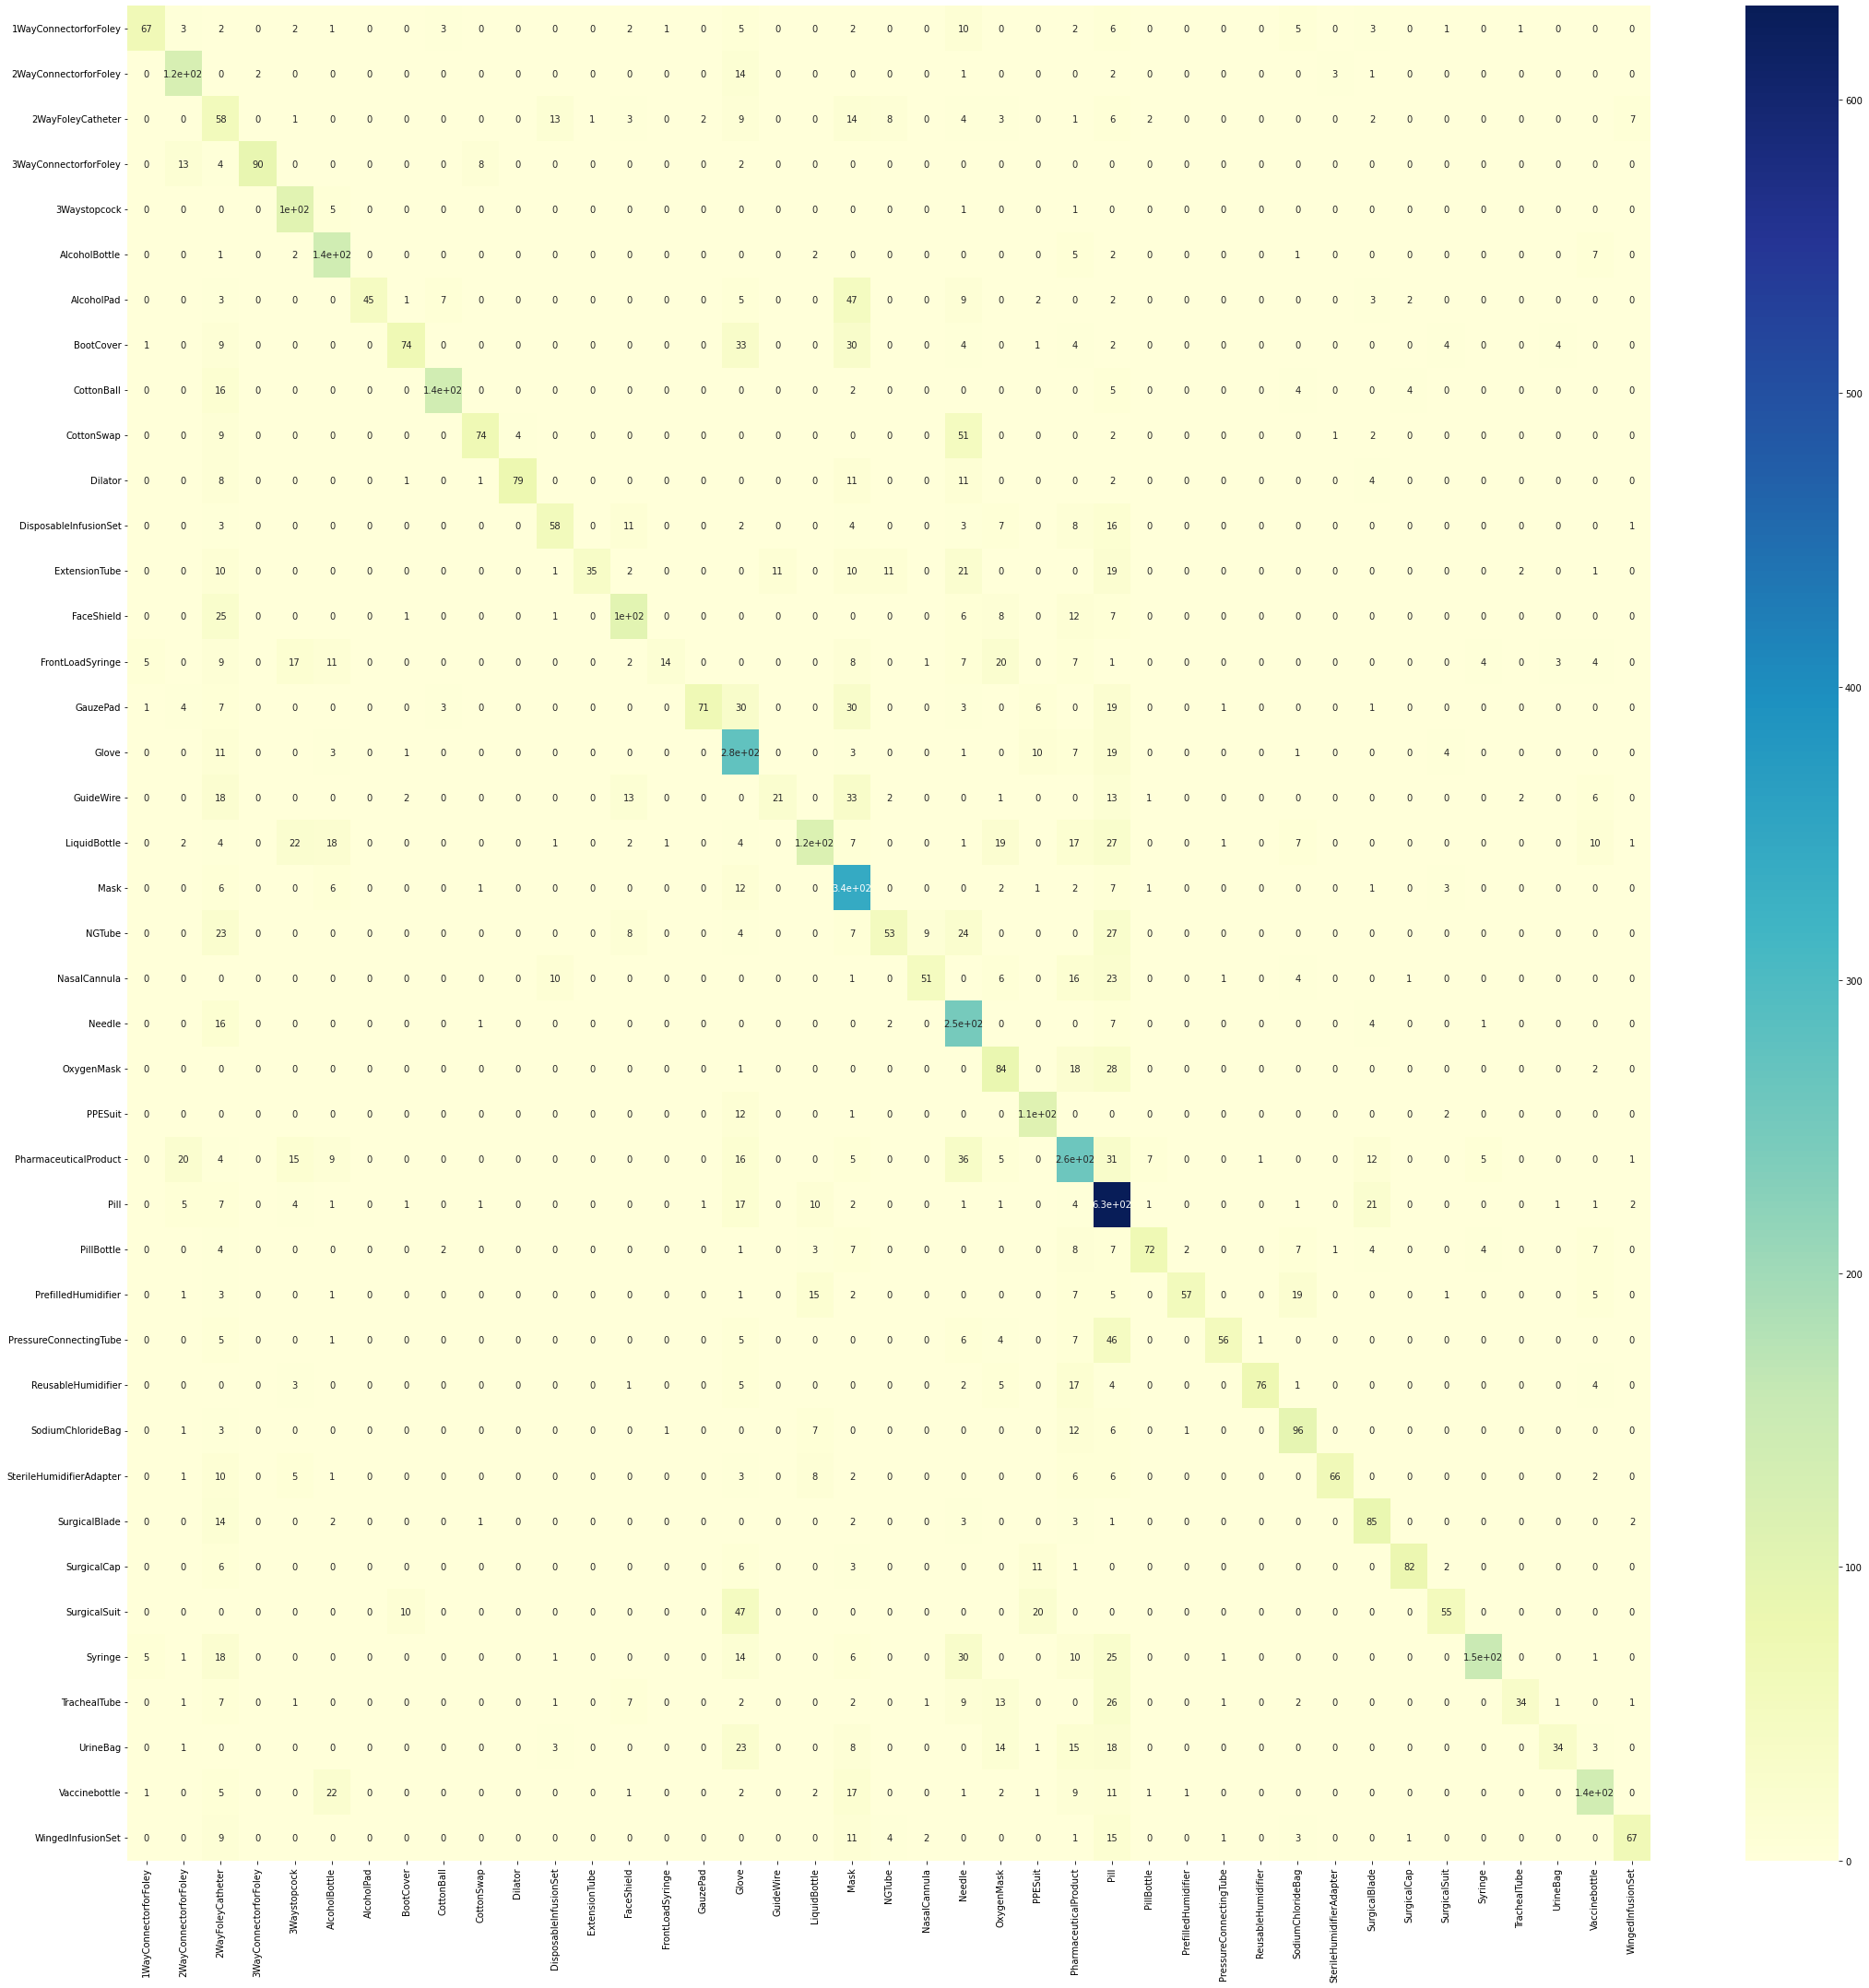

In [39]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

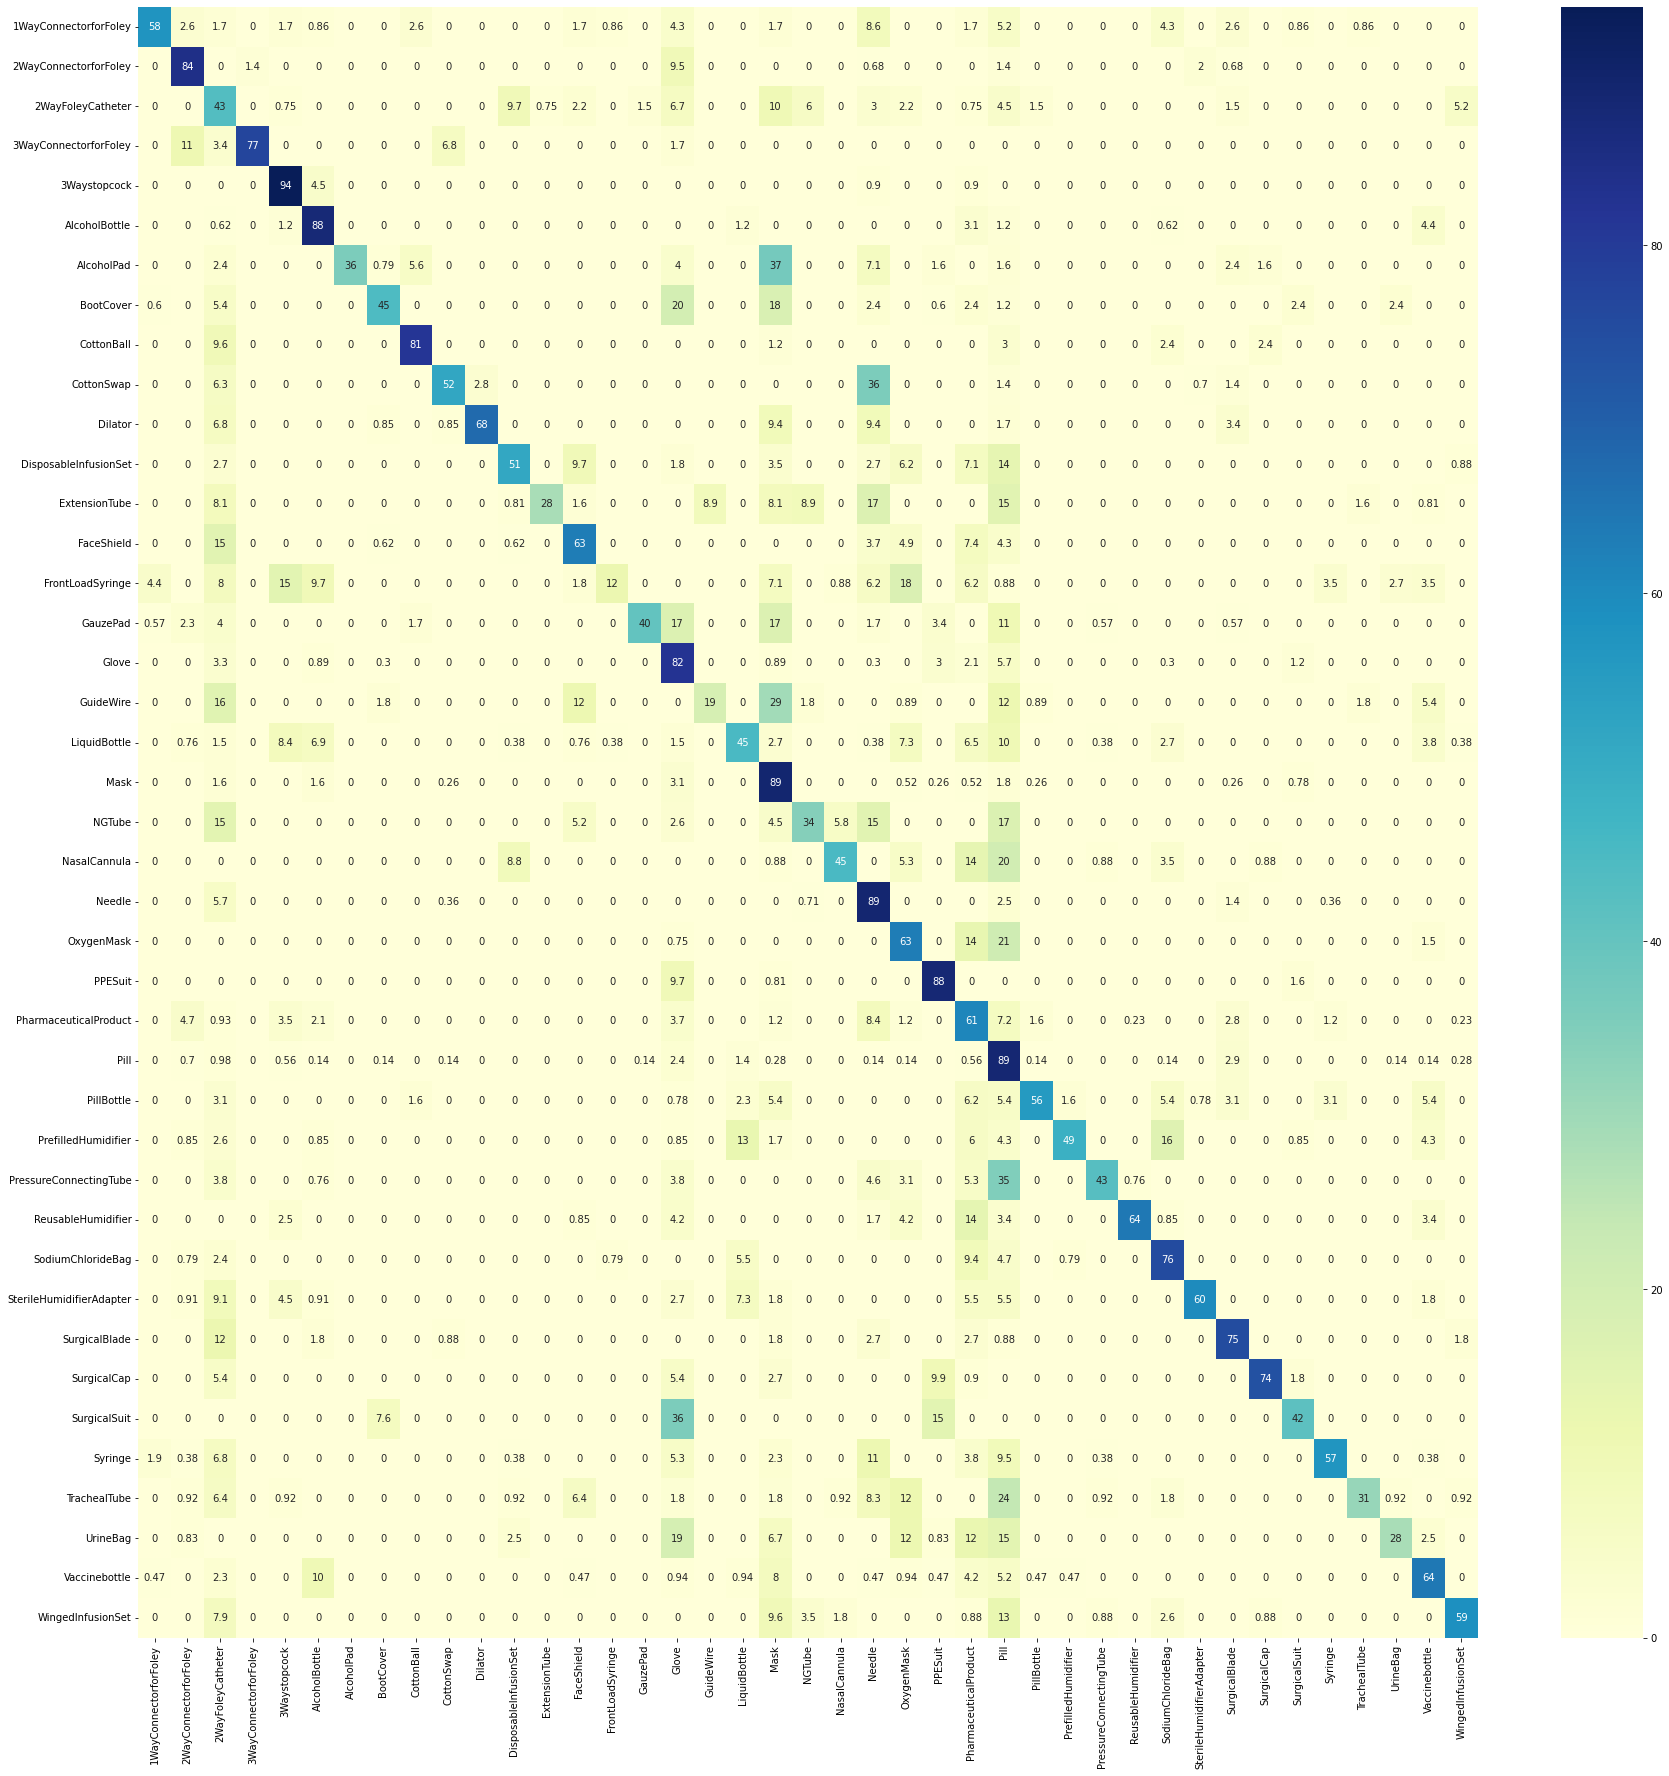

In [52]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")